In [30]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier, DMatrix, cv
from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.model_selection import ParameterGrid

## Load Data

In [31]:
train_clean = joblib.load('data/train_clean.pckl')
test_clean = joblib.load('data/test_clean.pckl')

#X = joblib.load('data/X.pckl')
X_tfidf = joblib.load('data/X_tfidf.pckl')
X_svd = joblib.load('data/X_svd.pckl')

#X_test = joblib.load('data/X_test.pckl')
X_test_tfidf = joblib.load('data/X_test_tfidf.pckl')
X_test_svd = joblib.load('data/X_test_svd.pckl')

In [32]:
# Create data sets to hold CV predictions on training data for stacked model fit

stack_train = train_clean[['id','toxic','severe_toxic','obscene','threat','insult','identity_hate']].copy()

## Create Folds to Use Across Methods

In [33]:
skf = StratifiedKFold(n_splits=10, random_state=678246569, shuffle=True)

## Naive Bayes

In [34]:
model = 'NB'
mbayes = MultinomialNB()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    stack_train[model+'_'+target] = np.nan

    for train, test in skf.split(X_tfidf, train_clean[target]):
        mbayes.fit(X_tfidf[train, :], train_clean.loc[train, target])
        preds = mbayes.predict_proba(X_tfidf[test, :])
        stack_train.loc[test, model+'_'+target] = preds[:,1]
        
#         fpr, tpr, thresholds = roc_curve(train_clean.loc[test, target], preds[:,1], pos_label=1)
#         roc_auc = auc(fpr, tpr)
#         print(roc_auc)

In [35]:
stack_train.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,NB_toxic,NB_severe_toxic,NB_obscene,NB_threat,NB_insult,NB_identity_hate
0,0000997932d777bf,0,0,0,0,0,0,0.000072,1.523027e-07,0.000008,2.718901e-08,0.000008,1.345856e-07
1,000103f0d9cfb60f,0,0,0,0,0,0,0.000916,1.319286e-05,0.000212,2.449853e-06,0.000157,9.285133e-06
2,000113f07ec002fd,0,0,0,0,0,0,0.000098,5.031757e-08,0.000009,5.857017e-09,0.000006,4.529827e-08
3,0001b41b1c6bb37e,0,0,0,0,0,0,0.000012,2.935742e-08,0.000002,5.856117e-09,0.000002,3.401068e-08
4,0001d958c54c6e35,0,0,0,0,0,0,0.015519,2.742424e-04,0.005280,7.348771e-05,0.004632,2.977539e-04


## Regularized Logistic Regression

In [36]:
model = 'LOG'

final_c = {'toxic':20,
           'severe_toxic':2,
           'obscene':9,
           'threat':11,
           'insult':7,
           'identity_hate':9}

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    stack_train[model+'_'+target] = np.nan

    for train, test in skf.split(X_tfidf, train_clean[target]):
        log = LogisticRegression(C=final_c[target]).fit(X_tfidf[train,:], train_clean.loc[train, target])
        preds = log.predict_proba(X_tfidf[test, :])
        stack_train.loc[test, model+'_'+target] = preds[:,1]

#         fpr, tpr, thresholds = roc_curve(train_clean.loc[test, target], preds[:,1], pos_label=1)
#         roc_auc = auc(fpr, tpr)
#         print(roc_auc)

In [37]:
stack_train.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,NB_toxic,NB_severe_toxic,NB_obscene,NB_threat,NB_insult,NB_identity_hate,LOG_toxic,LOG_severe_toxic,LOG_obscene,LOG_threat,LOG_insult,LOG_identity_hate
0,0000997932d777bf,0,0,0,0,0,0,0.000072,1.523027e-07,0.000008,2.718901e-08,0.000008,1.345856e-07,0.002438,0.002235,0.001533,0.000273,0.002588,0.000460
1,000103f0d9cfb60f,0,0,0,0,0,0,0.000916,1.319286e-05,0.000212,2.449853e-06,0.000157,9.285133e-06,0.005042,0.003524,0.003219,0.000489,0.002749,0.000847
2,000113f07ec002fd,0,0,0,0,0,0,0.000098,5.031757e-08,0.000009,5.857017e-09,0.000006,4.529827e-08,0.011013,0.001905,0.012241,0.000242,0.010170,0.000503
3,0001b41b1c6bb37e,0,0,0,0,0,0,0.000012,2.935742e-08,0.000002,5.856117e-09,0.000002,3.401068e-08,0.000254,0.001223,0.001186,0.000191,0.000908,0.000395
4,0001d958c54c6e35,0,0,0,0,0,0,0.015519,2.742424e-04,0.005280,7.348771e-05,0.004632,2.977539e-04,0.006478,0.004399,0.014154,0.000831,0.018076,0.002973


## LDA w/ SVD Decomp

In [38]:
model = 'LDA'

final_shrinkage = {'toxic': .4,
                   'severe_toxic': .8,
                   'obscene': .5,
                   'threat': .8,
                   'insult': .5,
                   'identity_hate': .7}

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    stack_train[model+'_'+target] = np.nan

    for train, test in skf.split(X_tfidf, train_clean[target]):
        lda = LinearDiscriminantAnalysis(shrinkage=final_shrinkage[target], solver='eigen')
        lda.fit(X_svd[train, :], train_clean.loc[train, target])
        preds = lda.predict_proba(X_svd[test, :])
        stack_train.loc[test, model+'_'+target] = preds[:,1]

In [39]:
stack_train.head().transpose()

,0,1,2,3,4
id,0000997932d777bf,000103f0d9cfb60f,000113f07ec002fd,0001b41b1c6bb37e,0001d958c54c6e35
toxic,0,0,0,0,0
severe_toxic,0,0,0,0,0
obscene,0,0,0,0,0
threat,0,0,0,0,0
insult,0,0,0,0,0
identity_hate,0,0,0,0,0
NB_toxic,7.18358e-05,0.000915659,9.83415e-05,1.20258e-05,0.0155186
NB_severe_toxic,1.52303e-07,1.31929e-05,5.03176e-08,2.93574e-08,0.000274242
NB_obscene,7.73267e-06,0.000211522,8.72534e-06,2.0504e-06,0.00527961


In [40]:
joblib.dump(stack_train, 'data/stacking_train.pckl')

['data/stacking_train.pckl']

In [41]:
stack_train.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,NB_toxic,NB_severe_toxic,NB_obscene,...,LOG_obscene,LOG_threat,LOG_insult,LOG_identity_hate,LDA_toxic,LDA_severe_toxic,LDA_obscene,LDA_threat,LDA_insult,LDA_identity_hate
0,0000997932d777bf,0,0,0,0,0,0,0.000072,1.523027e-07,0.000008,...,0.001533,0.000273,0.002588,0.000460,0.095710,0.009908,0.052792,0.002986,0.049240,0.008775
1,000103f0d9cfb60f,0,0,0,0,0,0,0.000916,1.319286e-05,0.000212,...,0.003219,0.000489,0.002749,0.000847,0.095704,0.009920,0.052794,0.002995,0.049241,0.008788
2,000113f07ec002fd,0,0,0,0,0,0,0.000098,5.031757e-08,0.000009,...,0.012241,0.000242,0.010170,0.000503,0.095862,0.009932,0.052878,0.002990,0.049322,0.008796
3,0001b41b1c6bb37e,0,0,0,0,0,0,0.000012,2.935742e-08,0.000002,...,0.001186,0.000191,0.000908,0.000395,0.095657,0.009902,0.052765,0.002985,0.049214,0.008774
4,0001d958c54c6e35,0,0,0,0,0,0,0.015519,2.742424e-04,0.005280,...,0.014154,0.000831,0.018076,0.002973,0.095785,0.009922,0.052835,0.002991,0.049281,0.008789


## Process and Store Stacking Data

In [21]:
# create target level X df's with standardized features, and saved scaler transformers

x_dfs = dict()
m_list = ['NB_', 'LOG_', 'LDA_']

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    X = stack_train[[item+target for item in m_list]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    x_dfs[target] = scaler, X_scaled

In [23]:
s1 = pd.read_csv('data/S1_baselineNB.csv')
s3 = pd.read_csv('data/S3_lda_svd.csv')
s4 = pd.read_csv('data/S4_logistic_tuned.csv')

In [24]:
# process test data (base model scores) for scoring stacked models

x_dfs_test = dict()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    X = pd.concat([s1[target], s4[target], s3[target]], axis=1)
    X.columns = ['NB_'+target, 'LOG_'+target, 'LDA_'+target]
    scaler = x_dfs[target][0]
    x_dfs_test[target] = scaler.transform(X)

In [5]:
# joblib.dump(x_dfs, 'data/stacking_train_xdfs.pckl')
# joblib.dump(x_dfs_test, 'data/stacking_test_xdfs.pckl')

x_dfs = joblib.load('data/stacking_train_xdfs.pckl')
x_dfs_test = joblib.load('data/stacking_test_xdfs.pckl')

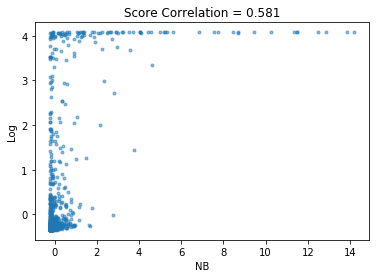

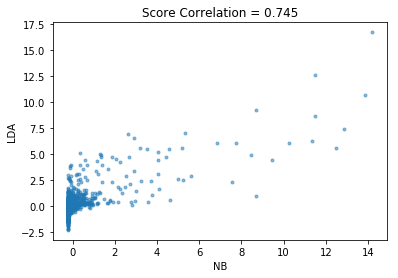

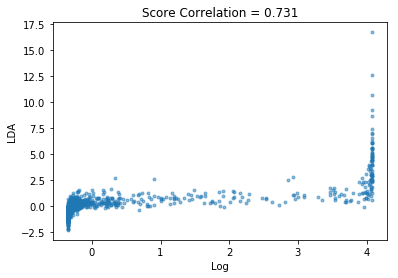

In [57]:

sampsize = 2000

temp = pd.DataFrame(x_dfs['toxic'][1]).sample(sampsize, axis=0)
temp.columns=['NB','Log','LDA']

for comb in combinations(temp.columns, 2):
    corr = np.corrcoef(temp[comb[0]], temp[comb[1]])

    plt.plot(temp[comb[0]], temp[comb[1]], '.', alpha=.5)
    plt.title('Score Correlation = %0.3f' % corr[0,1])
    plt.axis('tight')
    plt.xlabel(comb[0])
    plt.ylabel(comb[1])
    plt.show()

In [55]:
params = {'toxic'           : {'C': np.arange(.0005,.0021,.00005)},
          'severe_toxic'    : {'C': np.arange(.0001,.002,.0001)},
          'obscene'         : {'C': np.arange(.001,.01,.001)},
          'threat'          : {'C': np.arange(.0001,.0015,.0001)},
          'insult'          : {'C': np.arange(.001,.002,.0001)},
          'identity_hate'   : {'C': np.arange(.00015,.00045,.00005)}}


for target in ['toxic']: #,'severe_toxic','obscene','threat','insult','identity_hate']:

    #X = stack_train[['NB_'+target, 'LOG_'+target, 'LDA_'+target]]
    X = stack_train[['LDA_'+target, 'NB_'+target,]]

    print(target.upper())
    print()
    
    for train, test in skf.split(X, train_clean[target]):

        stack = LogisticRegression() #C=final_c[target])

        stack.fit(X.loc[train], stack_train.loc[train, target])

        scores = stack.predict_proba(X.loc[test])[:,1]
        
        fpr, tpr, thresholds = roc_curve(stack_train.loc[test, target], scores, pos_label=1)
        roc_auc_stack = auc(fpr, tpr)
        
        fpr, tpr, thresholds = roc_curve(stack_train.loc[test, target], stack_train.loc[test, 'LOG_'+target], pos_label=1)
        roc_auc_log = auc(fpr, tpr)
        
        fpr, tpr, thresholds = roc_curve(stack_train.loc[test, target], stack_train.loc[test, 'LDA_'+target], pos_label=1)
        roc_auc_lda = auc(fpr, tpr)
        
        fpr, tpr, thresholds = roc_curve(stack_train.loc[test, target], stack_train.loc[test, 'NB_'+target], pos_label=1)
        roc_auc_nb = auc(fpr, tpr)
        
        print(round(roc_auc_stack,4), round(roc_auc_log,4), round(roc_auc_lda,4), round(roc_auc_nb,4))

TOXIC

0.8474 0.9702 0.921 0.8472
0.851 0.9733 0.9238 0.8508
0.8424 0.9731 0.9267 0.8421
0.8578 0.9758 0.9312 0.8575
0.8416 0.9732 0.9259 0.8414
0.8457 0.9761 0.9287 0.8454
0.8555 0.9716 0.9213 0.8553
0.8501 0.9718 0.9284 0.8499
0.8559 0.9735 0.9324 0.8557
0.8452 0.9736 0.9264 0.8449


In [50]:
for train, test in skf.split(stack_train, train_clean[target]):
    print(len(train))

143613
143613
143613
143613
143614
143614
143614
143615
143615
143615


## Stacking

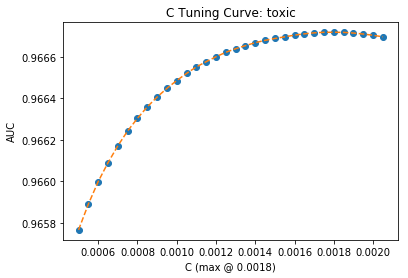

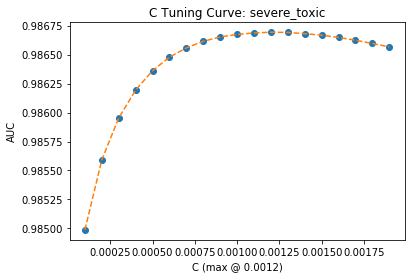

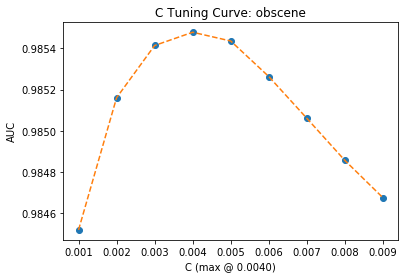

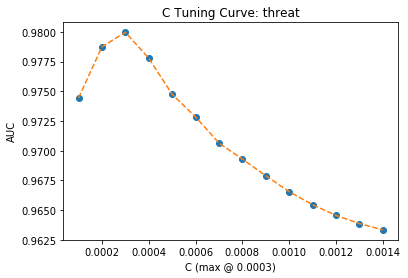

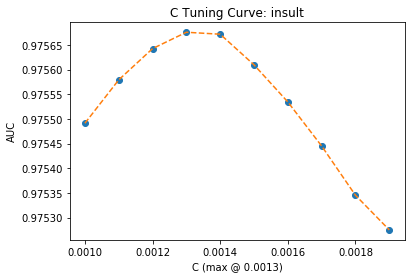

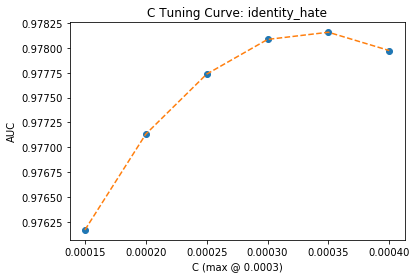

In [121]:
# tune C params for regularized logistic stacked model

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    stack = LogisticRegression(fit_intercept=False)

    params = {'toxic'           : {'C': np.arange(.0005,.0021,.00005)},
              'severe_toxic'    : {'C': np.arange(.0001,.002,.0001)},
              'obscene'         : {'C': np.arange(.001,.01,.001)},
              'threat'          : {'C': np.arange(.0001,.0015,.0001)},
              'insult'          : {'C': np.arange(.001,.002,.0001)},
              'identity_hate'   : {'C': np.arange(.00015,.00045,.00005)}}

    estimator = GridSearchCV(stack, 
                            params[target],
                            scoring='roc_auc',
                            n_jobs=3,
                            cv=StratifiedKFold(5))

    estimator.fit(x_dfs[target][1], stack_train[target])

    x = np.ma.getdata(estimator.cv_results_['param_C']).astype(np.float)
    y = estimator.cv_results_['mean_test_score']
    plt.plot(x, y, 'o', x, y , '--')
    plt.title('C Tuning Curve: '+target)
    plt.axis('tight')
    plt.xlabel('C (max @ %0.4f)' % x[np.argmax(y)])
    plt.ylabel('AUC')
    plt.show()

In [134]:
# fit final stacked models on full training data (CV base model scores) and score on test data

final_c = {'toxic':          0.0018,
           'severe_toxic':   0.0012,
           'obscene':        0.0040,
           'threat':         0.0003,
           'insult':         0.0013,
           'identity_hate':  0.0003}

scores_stacked = s1[['id']].copy()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    stack = LogisticRegression(C=final_c[target],
                               fit_intercept=False)

    stack.fit(x_dfs[target][1], stack_train[target])
    
    scores_stacked[target] = stack.predict_proba(x_dfs_test[target])[:,1]
    
scores_stacked.to_csv('data/S5_stacked.csv', index=False)
scores_stacked.head(20)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.000000,0.921444,1.000000,0.660360,1.000000,0.995894
1,0000247867823ef7,0.153295,0.487513,0.143140,0.496954,0.292070,0.487509
2,00013b17ad220c46,0.425445,0.500779,0.355275,0.500622,0.464780,0.498553
3,00017563c3f7919a,0.134809,0.481433,0.134779,0.495891,0.278414,0.485173
4,00017695ad8997eb,0.187964,0.483287,0.161708,0.495963,0.316485,0.486661
5,0001ea8717f6de06,0.141222,0.479717,0.136563,0.495721,0.290865,0.485158
6,00024115d4cbde0f,0.133509,0.476589,0.132349,0.495037,0.275710,0.485066
7,000247e83dcc1211,0.999952,0.494858,0.326938,0.499094,0.727220,0.499328
8,00025358d4737918,0.142867,0.483310,0.150488,0.496718,0.298215,0.487798
9,00026d1092fe71cc,0.136683,0.480513,0.134008,0.495737,0.278778,0.485914


Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)


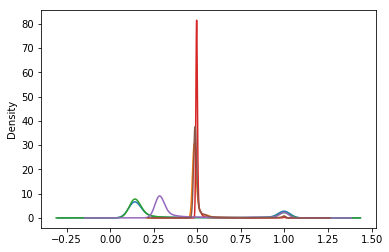

In [137]:
for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    print(scores_stacked[target].plot.density())

## xgboost Stacked Classifier

In [53]:
# basic parameter tuning for xbgoost staking model

target = 'toxic'

X_train, X_test, y_train, y_test = train_test_split(
    x_dfs[target][1], train_clean[target], test_size=0.33, random_state=58183)

xgb = XGBClassifier(max_depth=3, 
              learning_rate=0.1, 
              n_estimators=50, 
              silent=True, 
              objective='binary:logistic', 
              booster='gbtree', 
              n_jobs=3, 
              gamma=0, 
              min_child_weight=1, 
              max_delta_step=0, 
              subsample=1, 
              colsample_bytree=1, 
              colsample_bylevel=1, 
              reg_alpha=0, 
              reg_lambda=1, 
              scale_pos_weight=1, 
              base_score=0.5, 
              random_state=0, 
              seed=None, 
              missing=None)

# xgb.fit(X_train, 
#         y_train, 
#         eval_set=[(X_test, y_test)], 
#         eval_metric='auc', 
#         early_stopping_rounds=10,
#         verbose=1)

params = {'learning_rate': [.05, .1],
         'max_depth': [3, 5]}

estimator = GridSearchCV(xgb, 
                        params,
                        scoring='roc_auc',
                        n_jobs=1,
                        cv=StratifiedKFold(3))

estimator.fit(X_train, 
    y_train)

    
#     estimator.fit(X_train, 
#         y_train, 
#         eval_set=[(X_test, y_test)], 
#         eval_metric='auc', 
#         early_stopping_rounds=10,
#         verbose=1)

#     x = np.ma.getdata(estimator.cv_results_['param_C']).astype(np.float)
#     y = estimator.cv_results_['mean_test_score']
#     plt.plot(x, y, 'o', x, y , '--')
#     plt.title('C Tuning Curve: '+target)
#     plt.axis('tight')
#     plt.xlabel('C (max @ %0.4f)' % x[np.argmax(y)])
#     plt.ylabel('AUC')
#     plt.show()

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=3, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [38]:
preds = xgb.predict_proba(x_dfs_test[target])[:,1]

In [54]:
estimator.cv_results_

{'mean_fit_time': array([ 0.98039522,  1.53325033,  0.98887129,  1.55471263]),
 'mean_score_time': array([ 0.01452103,  0.01849699,  0.01448226,  0.02064424]),
 'mean_test_score': array([ 0.97226091,  0.97264252,  0.97309082,  0.97315068]),
 'mean_train_score': array([ 0.97311374,  0.97483979,  0.97430703,  0.97672479]),
 'param_learning_rate': masked_array(data = [0.05 0.05 0.1 0.1],
              mask = [False False False False],
        fill_value = ?),
 'param_max_depth': masked_array(data = [3 5 3 5],
              mask = [False False False False],
        fill_value = ?),
 'params': ({'learning_rate': 0.05, 'max_depth': 3},
  {'learning_rate': 0.05, 'max_depth': 5},
  {'learning_rate': 0.1, 'max_depth': 3},
  {'learning_rate': 0.1, 'max_depth': 5}),
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([ 0.97460041,  0.97479624,  0.97518224,  0.97520059]),
 'split0_train_score': array([ 0.9726705 ,  0.97450114,  0.97382188,  0.97635767]),
 'split1_test

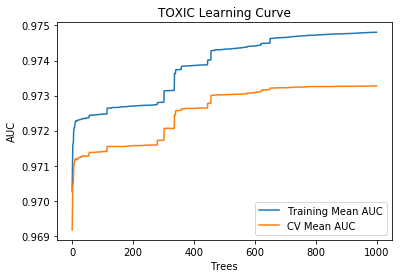

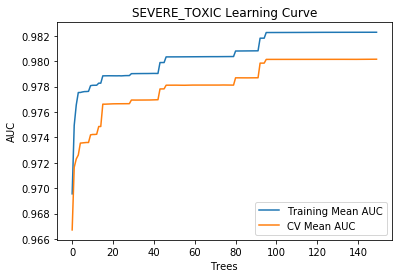

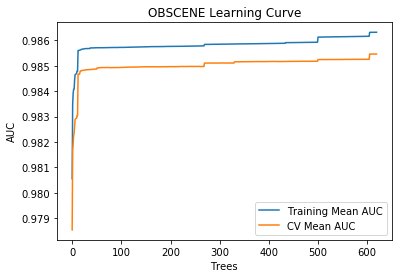

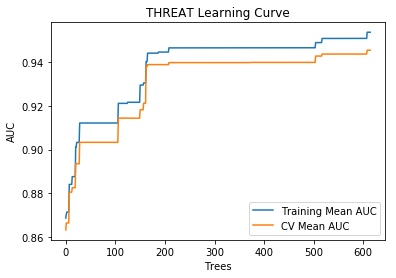

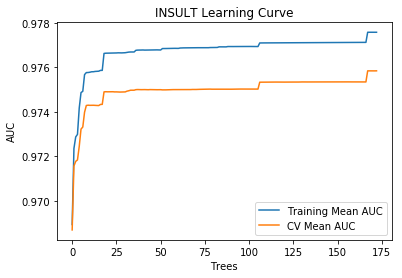

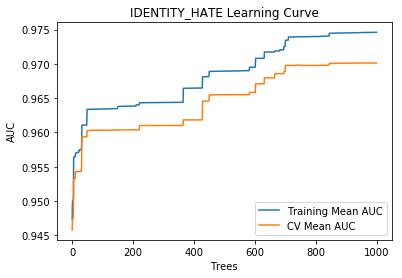

In [44]:
for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    dtrain = DMatrix(x_dfs[target][1], train_clean[target])

    params = {'learning_rate': .001,
             'subsample': .7,
             'min_child_weight': 10,
             'objective': 'binary:logistic', 
             'booster': 'gbtree'}

    results = cv(params, 
           dtrain,
           num_boost_round=1000, 
           nfold=3, 
           stratified=True, 
           metrics=('auc'),
           early_stopping_rounds=100)

    plt.plot(results.index, results['train-auc-mean'], '-', label='Training Mean AUC')
    plt.plot(results.index, results['test-auc-mean'], '-', label='CV Mean AUC')
    plt.title(target.upper()+' Learning Curve')
    plt.axis('tight')
    plt.xlabel('Trees')
    plt.ylabel('AUC')
    plt.legend(loc="lower right")
    plt.show()

In [45]:
results

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.945778,0.008198,0.947387,0.005060
1,0.947264,0.007219,0.949870,0.006179
2,0.947343,0.007170,0.950001,0.006157
3,0.947371,0.007193,0.950073,0.006274
4,0.948074,0.006455,0.950421,0.006363
5,0.953150,0.010752,0.956359,0.003823
6,0.953175,0.010765,0.956392,0.003824
7,0.953188,0.010761,0.956392,0.003826
8,0.953213,0.010769,0.956474,0.003913
9,0.953220,0.010789,0.956470,0.003935


In [1]:
from itertools import combinations
from sklearn.model_selection import ParameterGrid

In [13]:
grid_results = list()

pgrid = ParameterGrid({'learning_rate': [.001],
                         'max_depth': [3,5,7],
                         'subsample': [.5,.7],
                         'min_child_weight': [5,10,20],
                         'objective': ['binary:logistic'], 
                         'booster': ['gbtree']})

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    dtrain = DMatrix(x_dfs[target][1], train_clean[target])

    for p in pgrid:

        results = cv(p, 
               dtrain,
               num_boost_round=1000, 
               nfold=3, 
               stratified=True, 
               metrics=('auc'),
               early_stopping_rounds=100)
        
        p['auc'] = max(results['test-auc-mean'])
        p['ntrees'] = len(results)
        p['target'] = target
        
        grid_results.append(p)

In [14]:
joblib.dump(pd.DataFrame(grid_results), 'data/xgb_grid_results.pckl')

['data/xgb_grid_results.pckl']

In [15]:
pd.DataFrame(grid_results)

,auc,booster,learning_rate,max_depth,min_child_weight,ntrees,objective,subsample,target
0,0.971342,gbtree,0.001,3,5,1000,binary:logistic,0.5,toxic
1,0.971013,gbtree,0.001,3,5,1000,binary:logistic,0.7,toxic
2,0.971341,gbtree,0.001,3,10,1000,binary:logistic,0.5,toxic
3,0.971013,gbtree,0.001,3,10,1000,binary:logistic,0.7,toxic
4,0.971335,gbtree,0.001,3,20,1000,binary:logistic,0.5,toxic
5,0.970924,gbtree,0.001,3,20,1000,binary:logistic,0.7,toxic
6,0.973489,gbtree,0.001,5,5,1000,binary:logistic,0.5,toxic
7,0.973244,gbtree,0.001,5,5,1000,binary:logistic,0.7,toxic
8,0.973511,gbtree,0.001,5,10,1000,binary:logistic,0.5,toxic
9,0.973251,gbtree,0.001,5,10,1000,binary:logistic,0.7,toxic


In [29]:
res = pd.DataFrame(grid_results)
ids = res.groupby(['target'])['auc'].idxmax()
np.mean(res.loc[ids]['auc'])

0.9747246111111112